Melhor posição encontrada: x = 0.030303030303030276, y = 1.6060606060606064
Valor máximo encontrado: 8.084135710177243


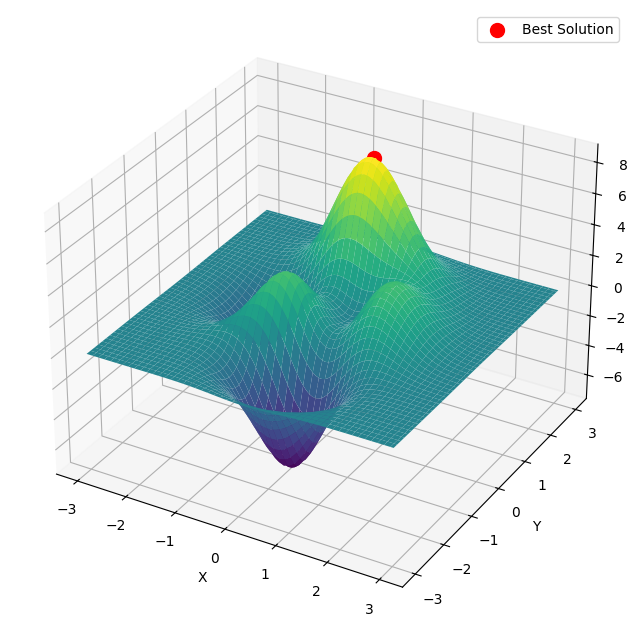

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Definir a função Peaks
def peaks_function(x, y):
    return (3 * (1 - x)**2 * np.exp(-x**2 - (y + 1)**2) 
            - 10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2) 
            - 1/3 * np.exp(-(x + 1)**2 - y**2))

# Algoritmo Híbrido ACO-GA
class HybridACO_GA:
    def __init__(self, population_size, num_generations, grid_size, mutation_rate, crossover_rate, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_constant):
        self.population_size = population_size
        self.num_generations = num_generations
        self.grid_size = grid_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone_constant = pheromone_constant

        # População inicial (cromossomos)
        self.population = np.random.randint(0, grid_size, (population_size, 2))
        self.best_position = None
        self.best_value = -float('inf')
        
        # Feromônios
        self.pheromone_levels = np.ones((grid_size, grid_size))

        # Criar o grid de valores x e y no domínio [-3, 3]
        self.x = np.linspace(-3, 3, grid_size)
        self.y = np.linspace(-3, 3, grid_size)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def run(self):
        for generation in range(self.num_generations):
            # Avaliar a população
            fitness_values = self.evaluate_population()

            # Seleção: Torneio para escolher os pais
            selected_parents = self.selection(fitness_values)

            # Cruzamento e mutação
            new_population = []
            for i in range(0, self.population_size, 2):
                parent1, parent2 = selected_parents[i], selected_parents[i+1]
                offspring1, offspring2 = self.crossover(parent1, parent2)
                new_population.append(offspring1)
                new_population.append(offspring2)

            # Mutação na população
            self.mutation(new_population)

            # Atualizar a população
            self.population = np.array(new_population)

            # ACO: Exploração local com formigas
            self.aco_exploration()

            # Atualizar o melhor valor encontrado
            fitness_values = self.evaluate_population()
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_value:
                self.best_value = fitness_values[best_idx]
                self.best_position = self.population[best_idx]

        return self.best_position, self.best_value

    def evaluate_population(self):
        fitness_values = []
        for individual in self.population:
            x, y = individual
            fitness = peaks_function(x, y)
            fitness_values.append(fitness)
        return np.array(fitness_values)

    def selection(self, fitness_values):
        # Seleção por torneio
        selected = []
        for _ in range(self.population_size):
            tournament = np.random.choice(self.population_size, 4)
            best_idx = tournament[np.argmax(fitness_values[tournament])]
            selected.append(self.population[best_idx])
        return np.array(selected)

    def crossover(self, parent1, parent2):
        # Crossover simples de 1 ponto
        crossover_point = np.random.randint(0, 2)
        offspring1 = np.copy(parent1)
        offspring2 = np.copy(parent2)
        offspring1[crossover_point:] = parent2[crossover_point:]
        offspring2[crossover_point:] = parent1[crossover_point:]
        return offspring1, offspring2

    def mutation(self, new_population):
        # Mutação: alteração aleatória de um gene
        for i in range(len(new_population)):
            if np.random.rand() < self.mutation_rate:
                mutation_point = np.random.randint(0, 2)
                new_population[i][mutation_point] = np.random.randint(0, self.grid_size)

    def aco_exploration(self):
        # Exploração das soluções com formigas
        solutions = []
        solution_values = []

        for ant in range(self.num_ants):
            # Cada formiga começa com uma solução aleatória
            x_idx, y_idx = self.construct_solution()
            solutions.append((x_idx, y_idx))
            value = peaks_function(self.x[x_idx], self.y[y_idx])
            solution_values.append(value)

            # Atualizar o melhor valor encontrado
            if value > self.best_value:
                self.best_value = value
                self.best_position = (self.x[x_idx], self.y[y_idx])

        # Atualizar feromônios após cada iteração de formigas
        self.update_pheromones(solutions, solution_values)

    def construct_solution(self):
        # Construção da solução pelas formigas
        x_idx = np.random.randint(0, self.grid_size)
        y_idx = np.random.randint(0, self.grid_size)

        for _ in range(10):  # Número de passos da formiga
            neighbors = self.get_neighbors(x_idx, y_idx)
            probabilities = self.calculate_probabilities(x_idx, y_idx, neighbors)
            next_point = np.random.choice(len(neighbors), p=probabilities)
            x_idx, y_idx = neighbors[next_point]

        return x_idx, y_idx

    def get_neighbors(self, x_idx, y_idx):
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x_idx + dx, y_idx + dy
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append((nx, ny))
        return neighbors

    def calculate_probabilities(self, x_idx, y_idx, neighbors):
        pheromones = np.array([self.pheromone_levels[nx, ny] for nx, ny in neighbors])
        values = np.array([peaks_function(self.x[nx], self.y[ny]) for nx, ny in neighbors])

        # Garantir que os valores sejam positivos
        values = values - values.min() + 1e-6  # Shift para evitar valores negativos ou zero

        desirability = pheromones**self.alpha * values**self.beta
        desirability = np.clip(desirability, a_min=0, a_max=None)

        if desirability.sum() == 0:
            probabilities = np.ones(len(neighbors)) / len(neighbors)
        else:
            probabilities = desirability / desirability.sum()
        
        probabilities = probabilities / probabilities.sum()

        return probabilities

    def update_pheromones(self, solutions, solution_values):
        self.pheromone_levels *= (1 - self.evaporation_rate)
        for (x_idx, y_idx), value in zip(solutions, solution_values):
            self.pheromone_levels[x_idx, y_idx] += self.pheromone_constant * value

# Executar o algoritmo híbrido ACO-GA
if __name__ == "__main__":
    grid_size = 100
    population_size = 50
    num_generations = 50
    mutation_rate = 0.1
    crossover_rate = 0.7
    num_ants = 50
    num_iterations = 100
    alpha = 1.0
    beta = 2.0
    evaporation_rate = 0.5
    pheromone_constant = 1.0

    # Inicializar e rodar o algoritmo híbrido
    hybrid_algorithm = HybridACO_GA(population_size, num_generations, grid_size, mutation_rate, crossover_rate, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_constant)
    best_position, best_value = hybrid_algorithm.run()

    print(f"Melhor posição encontrada: x = {best_position[0]}, y = {best_position[1]}")
    print(f"Valor máximo encontrado: {best_value}")

    # Plotar a solução
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(hybrid_algorithm.X, hybrid_algorithm.Y, peaks_function(hybrid_algorithm.X, hybrid_algorithm.Y), cmap='viridis')

    ax.scatter(best_position[0], best_position[1], best_value, color='r', s=100, label="Best Solution")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.show()


ValueError: Argument Z must be 2-dimensional.

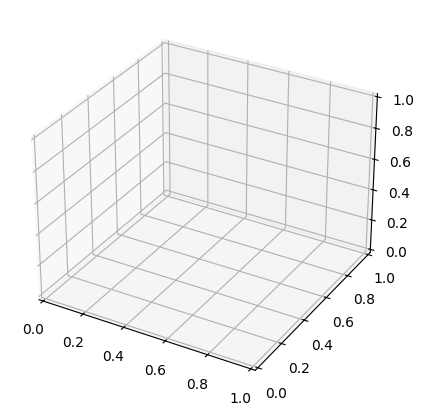

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Definir a função Peaks
def peaks_function(x, y):
    return (3 * (1 - x)**2 * np.exp(-x**2 - (y + 1)**2) 
            - 10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2) 
            - 1/3 * np.exp(-(x + 1)**2 - y**2))

# Plotar a solução
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(hybrid_algorithm.X, hybrid_algorithm.Y, peaks_function(hybrid_algorithm.X, hybrid_algorithm.Y), cmap='viridis')
plt.show()